## WELCOME TO CNN THAT I HAVE NO CLUE WHAT AM I DOING!!

### Ding Prcessing

In [1]:
import pandas as pd

In [6]:
df = pd.read_csv('test_a.csv')

In [11]:
df['font_size'] = 18

In [10]:
df['font'] = 'Sarabun-Regular'

In [12]:
df

,image_path,font,font_size,color
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,Sarabun-Regular,18,#26E953
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,Sarabun-Regular,18,#0000FF
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,Sarabun-Regular,18,#FF6666
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,Sarabun-Regular,18,#FF6666
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,Sarabun-Regular,18,#FF6666
...,...,...,...,...
2515,images/bb5c8429-0a43-4816-8b2f-6687b381e98f.jpg,Sarabun-Regular,18,#A020F0
2516,images/2dde11bf-6aaa-45e3-a16a-65e0a3e35c6a.jpg,Sarabun-Regular,18,#A020F0
2517,images/c8e2da57-f55f-47d0-b664-908d4006a39f.jpg,Sarabun-Regular,18,#FF6666
2518,images/1bd9e291-3476-4560-b807-86f94ea3b8ad.jpg,Sarabun-Regular,18,#0000FF


In [13]:
df.to_csv('test_b.csv',index=0)

### Okay Okay CNN
Font size classify

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class ImprovedFontCNN(nn.Module):
    def __init__(self):
        super(ImprovedFontCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer to prevent overfitting
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10) # Fonts class
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [84]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root='fonts_size_dataset/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(root='fonts_size_dataset/valid', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [85]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = ImprovedFontCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 15  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/15], Loss: 1.8051
Epoch [2/15], Loss: 1.6677
Epoch [3/15], Loss: 1.6233
Epoch [4/15], Loss: 1.5984
Epoch [5/15], Loss: 1.5745
Epoch [6/15], Loss: 1.5543
Epoch [7/15], Loss: 1.5251
Epoch [8/15], Loss: 1.4968
Epoch [9/15], Loss: 1.4642
Epoch [10/15], Loss: 1.4195
Epoch [11/15], Loss: 1.3878
Epoch [12/15], Loss: 1.3480
Epoch [13/15], Loss: 1.3211
Epoch [14/15], Loss: 1.2867
Epoch [15/15], Loss: 1.2484


Accuracy: 47.62%


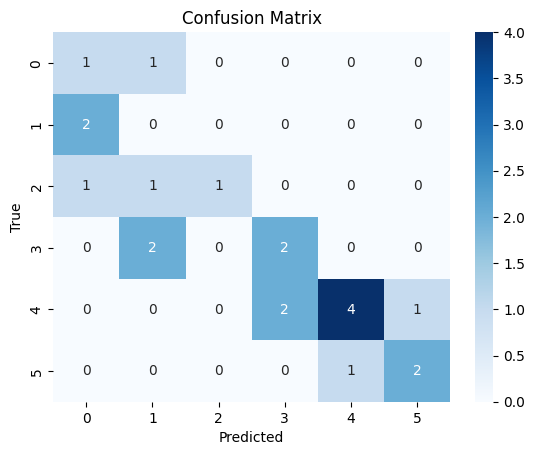

In [86]:
# Evaluate Model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
print(f'Accuracy: {accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [88]:
torch.save(model, 'font_size_model.pth')

In [75]:
test_a = pd.read_csv('test_a.csv')

In [76]:
test_a

,image_path,font,font_size,color
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,NaN,NaN,#26E953
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,NaN,NaN,#0000FF
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,NaN,NaN,#FF6666
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,NaN,NaN,#FF6666
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,NaN,NaN,#FF6666
...,...,...,...,...
2515,images/bb5c8429-0a43-4816-8b2f-6687b381e98f.jpg,NaN,NaN,#A020F0
2516,images/2dde11bf-6aaa-45e3-a16a-65e0a3e35c6a.jpg,NaN,NaN,#A020F0
2517,images/c8e2da57-f55f-47d0-b664-908d4006a39f.jpg,NaN,NaN,#FF6666
2518,images/1bd9e291-3476-4560-b807-86f94ea3b8ad.jpg,NaN,NaN,#0000FF


In [79]:
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image


In [118]:
def predict(model, image_path, device):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

# Example usage
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = torch.load('font_size_model.pth')

/var/folders/4n/0k9v2lsj56ng0ks9yr1s471h0000gn/T/ipykernel_32725/1195059004.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('font_size_model.pth')  #

In [99]:

image_path = 'fonts_size_dataset/train/24/0b65b086-ccb3-4aad-bff3-f6af4378906c.jpg'
predicted_class = predict(model, image_path, device)
print(f'Predicted class index: {predicted_class}')


Predicted class index: 4


In [119]:
for index, row in test_a.iterrows():
    
    image_path = row['image_path']
    predicted_class = predict(model, image_path, device)
    
    class_names = [18, 20, 22, 24, 26, 28]
    
    test_a['font_size'][index] = class_names[predicted_class]

In [104]:
test_a.to_csv('test_a.csv', index=0)

## Font types classify

In [105]:
import os
import shutil
import pandas as pd

df = pd.read_csv('train.csv')

base_dir = 'fonts_dataset'
threshold = 20

for index, row in df.iterrows():

    subfolder = 'train' if row['font_size'] > threshold else 'valid'
    
    font_folder = os.path.join(base_dir, subfolder, row['font'])
    if not os.path.exists(font_folder):
        os.makedirs(font_folder)
    
    shutil.move(row['image_path'], os.path.join(font_folder, os.path.basename(row['image_path'])))

print("Images have been organized into fonts_dataset.")

Images have been organized into fonts_dataset.


In [106]:
import cv2
import os

input_dir = 'fonts_dataset/train'
output_dir = input_dir

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def process_image(file_path, output_path):
    
    image = cv2.imread(file_path)
    
    if image is not None:

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=33, sigmaY=33)
        
        divide = cv2.divide(gray, blur, scale=255)
        
        # _, black_and_white_image = cv2.threshold(divide, 235, 255, cv2.THRESH_BINARY)
        
        cv2.imwrite(output_path, divide)
        
        print(f"Processed and saved: {file_path} to {output_path}")
    else:
        print(f"Failed to read image: {file_path}")

def process_directory(input_dir, output_dir):
    for root, dirs, files in os.walk(input_dir):

        relative_path = os.path.relpath(root, input_dir)
        output_root = os.path.join(output_dir, relative_path)
        
        if not os.path.exists(output_root):
            os.makedirs(output_root)
        
        for filename in files:

            file_path = os.path.join(root, filename)
            
            output_path = os.path.join(output_root, filename)

            process_image(file_path, output_path)

process_directory(input_dir, output_dir)


Processed and saved: fonts_dataset/train/KhaosuayThin/5da860bd-0ffa-4af2-85e9-911c7b35bf57.jpg to fonts_dataset/train/KhaosuayThin/5da860bd-0ffa-4af2-85e9-911c7b35bf57.jpg
Processed and saved: fonts_dataset/train/KhaosuayThin/48231159-eab2-4ac8-b832-3ec2822be158.jpg to fonts_dataset/train/KhaosuayThin/48231159-eab2-4ac8-b832-3ec2822be158.jpg
Processed and saved: fonts_dataset/train/KhaosuayThin/b2b27d25-5b83-4860-94b4-7ea0998e2aa9.jpg to fonts_dataset/train/KhaosuayThin/b2b27d25-5b83-4860-94b4-7ea0998e2aa9.jpg
Processed and saved: fonts_dataset/train/KhaosuayThin/1bc28895-de3b-4c41-b8b9-4af48d814b7c.jpg to fonts_dataset/train/KhaosuayThin/1bc28895-de3b-4c41-b8b9-4af48d814b7c.jpg
Processed and saved: fonts_dataset/train/KhaosuayThin/0dbad734-0fb9-4570-8987-910d212c0b88.jpg to fonts_dataset/train/KhaosuayThin/0dbad734-0fb9-4570-8987-910d212c0b88.jpg
Processed and saved: fonts_dataset/train/KhaosuayThin/1a0e31c0-d355-468b-bde9-7cc0b5651f0b.jpg to fonts_dataset/train/KhaosuayThin/1a0e31c0-

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

class ImprovedFontCNN(nn.Module):
    def __init__(self):
        super(ImprovedFontCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer to prevent overfitting
        
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10) # Fonts class
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

In [108]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root='fonts_dataset/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.ImageFolder(root='fonts_dataset/valid', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [109]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = ImprovedFontCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 15  # Increase the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/15], Loss: 1.9693
Epoch [2/15], Loss: 1.7206
Epoch [3/15], Loss: 1.3738
Epoch [4/15], Loss: 1.1188
Epoch [5/15], Loss: 0.9708
Epoch [6/15], Loss: 0.8604
Epoch [7/15], Loss: 0.7795
Epoch [8/15], Loss: 0.7066
Epoch [9/15], Loss: 0.6594
Epoch [10/15], Loss: 0.5823
Epoch [11/15], Loss: 0.5481
Epoch [12/15], Loss: 0.4809
Epoch [13/15], Loss: 0.4227
Epoch [14/15], Loss: 0.4023
Epoch [15/15], Loss: 0.3582


Accuracy: 40.00%


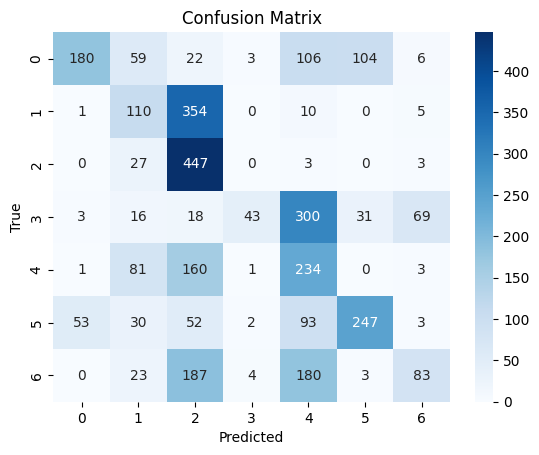

In [111]:
# Evaluate Model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * sum(np.array(all_labels) == np.array(all_preds)) / len(all_labels)
print(f'Accuracy: {accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [112]:
torch.save(model, 'font_model.pth')

In [113]:
test_a = pd.read_csv('test_a.csv')

In [120]:
test_a

,image_path,font,font_size,color
0,images/158b1476-5938-45dc-be90-9e50327c245d.jpg,KhaosuayThin,28,#26E953
1,images/da1628c5-6b4f-4ead-9514-e723355870e9.jpg,KhaosuayThin,22,#0000FF
2,images/f75a8720-bdfb-465d-977a-1c208d23b2cc.jpg,KhaosuayThin,26,#FF6666
3,images/ce67542f-d7d7-49ef-91f9-df686231154a.jpg,KhaosuayThin,18,#FF6666
4,images/10df170a-ee18-4dbb-b8bc-0f5cd47ea861.jpg,Prompt-Regular,24,#FF6666
...,...,...,...,...
2515,images/bb5c8429-0a43-4816-8b2f-6687b381e98f.jpg,NotoSerifThai-Regular,18,#A020F0
2516,images/2dde11bf-6aaa-45e3-a16a-65e0a3e35c6a.jpg,KhaosuayThin,20,#A020F0
2517,images/c8e2da57-f55f-47d0-b664-908d4006a39f.jpg,Prompt-Regular,28,#FF6666
2518,images/1bd9e291-3476-4560-b807-86f94ea3b8ad.jpg,Prompt-Regular,26,#0000FF


In [117]:
for index, row in test_a.iterrows():
    
    image_path = row['image_path']
    predicted_class = predict(model, image_path, device)
    
    class_names = ['Athiti-Regular', 'FkBeautyRegular', 'KhaosuayThin', 'Kodchasan-Regular', 'NotoSerifThai-Regular', 'Prompt-Regular', 'Sarabun-Regular']
    
    test_a['font'][index] = class_names[predicted_class]

/var/folders/4n/0k9v2lsj56ng0ks9yr1s471h0000gn/T/ipykernel_32725/160080265.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_a['font'][index] = class_names[predicted_class]
/var/folders/4n/0k9v2lsj56ng0ks9yr1s471h0000gn/T/ipykernel_32

In [122]:
test_a.to_csv('test_b.csv', index=0)